In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
import torch
import torch.nn as nn
import torch.optim as Adam
import matplotlib.pyplot as plt
from torch import nn

## 1. Baye's Theorem

M is a marker that determines genetic disposition to kidney disease. A chemical test can show if you are positive or negative for M. However, test is not 100% right.
y = +ve or -ve
x = marker (M) or no marker (no M)
$$
P[ +| M] = 0.95
$$
$$
P[- | no M] = 0.95
$$
$$
P[M] = 0.01
$$

### 1a.
Define the following quantities:
$$ P[-|M]; $$
$$ P[+|not M]; $$
$$ P[not M] $$

P[-|M] = 0.05

P[+|not M] = 0.05

P[not M] = 0.99

### 1b.
You have had a chemical test and have tested positive; should you be alarmed? To answer this, find what is the chance that a randomly selected person who tests positive for the marker actually has the marker by using Baye’s Theorem. What feature of the given data accounts for the result?

In [6]:
have_M = 0.01
have_M_test_pos = 0.95

no_M = 0.95
no_M_test_pos = 0.05

actually_have_M = have_M * have_M_test_pos
false_positive = no_M * no_M_test_pos

all_positive_tests = actually_have_M + false_positive
odds_that_Korede_has_M = actually_have_M / all_positive_tests

print(f'The odds that Korede actually has M are {round(odds_that_Korede_has_M, 4)}.')

The odds that Korede actually has M are 0.1667.


Thanks to Baye's Theorem, I would not be too worried about actually having M. The feature of the data that accounts for this result is the occurence of M in the population (0.01).

### 1c.
Suppose that frequency of marker was higher by a factor of 10, i.e. $$P[M] = 0.10$$ What is the chance that a randomly selected individual from this group who test positive actually has the marker?

New Scenario:

P[M] = 0.10

P[not M] = 0.90

In [8]:
have_M = 0.1
have_M_test_pos = 0.95

no_M = 0.90
no_M_test_pos = 0.05

actually_have_M = have_M * have_M_test_pos
false_positive = no_M * no_M_test_pos

all_positive_tests = actually_have_M + false_positive
odds_that_Korede_has_M = actually_have_M / all_positive_tests

print(f'The odds that Korede actually has M are {round(odds_that_Korede_has_M, 4)}!')

The odds that Korede actually has M are 0.6786!


Omg my odds are so much higher now. I would be worried.

## 2. Gaussian Naive Bayes
We will cluster 178 wines into 3 cultivars by solving with Naïve Bayes. To do this we will classify the wines by assigning them to the cultivar with the largest $$P(cultivar | X)$$ and to find this we must first define a labelled data set of $$P(wine  attribute  x | cultivar)$$ pairings to learn the relationship where x is one of the attributes, and do this for all attributes.

In [6]:
wines = pd.read_csv('data/wines.csv')

x = wines.drop(["Start assignment","ranking"],axis=1).values
y = wines['ranking'].values
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)
x_norm

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.29570023,  0.22769377,  1.84040254, ...,  0.36217728,
         0.44960118, -0.03787401],
       [ 2.25977152, -0.62508622, -0.7183361 , ...,  0.53767082,
         0.33660575,  0.94931905],
       ...,
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041],
       [-0.92721209, -0.54429654, -0.90110314, ...,  0.18668373,
         0.78858745, -0.7543851 ]])

### 2a.
How should we represent $$ P(wine attribute x | cultivar) $$ Given a wine that belongs to cultivar 1, what is the chance of it having an Alcohol % of 13 according to the probability distribution function?

In [7]:
class NaiveBayesClassifier():
    def __init__(self):
        self.type_indices = {}    # store the indices of wines that belong to each cultivar as a boolean array
        self.type_stats = {}      # store the mean and std of each cultivar
        self.ndata = 0
        self.trained = False
    
    @staticmethod
    def gaussian(x, mean, std):
        return 1 / (np.sqrt(2 * np.pi) * std) * np.exp(-(x - mean) **2 / (2 * std * 2))
    
    @staticmethod
    def calculate_statistics(x_values):
        # Returns a list with length of input features. Each element is a tuple, with the input feature's average and standard deviation
        n_feats = x_values.shape[1]
        return [(np.average(x_values[:, n]), np.std(x_values[:, n])) for n in range(n_feats)]
    
    @staticmethod
    def calculate_prob(x_input, stats):
        """Calculate the probability that the input features belong to a specific class(P(X|C)), defined by the statistics of features in that class
        x_input: np.array shape(nfeatures)
        stats: list of tuple [(mean1, std1), (means2,std2),...]
        """ 
        init_prob = 1.0
        # P(X|C) = P(x1|C)*P(x2|C)*... where each of them is a gaussian
        for x_value, single_stat in zip(x_input, stats):
            init_prob *= NaiveBayesClassifier.gaussian(x_value, *single_stat)
        return init_prob
    
    def fit(self,xs,ys):
        # Train the classifier by calculating the statistics of different features in each class
        self.ndata = len(ys)
        for y in set(ys):
            type_filter = (ys == y)
            self.type_indices[y] = type_filter
            self.type_stats[y] = self.calculate_statistics(xs[type_filter])
        self.trained = True
            
    def predict(self,xs):
        # Do the prediction by outputing the class that has highest probability
        if len(xs.shape) > 1:
            print("Only accepts one sample at a time!")
        if self.trained:
            guess = None
            max_prob = 0
            # P(C|X) = P(X|C)*P(C) / sum_i(P(X|C_i)*P(C_i)) (deniminator for normalization only, can be ignored)
            for y_type in self.type_stats:
                prob = self.calculate_prob(xs, self.type_stats[y_type])
                if prob > max_prob:
                    max_prob = prob
                    guess = y_type
                    # use to troubleshoot
                    # print (f'max prob {max_prob}, variable prob {prob}')
            return guess
        else:
            print("Please train the classifier first!")

I chose this function form because all the attributes are continuous; it is appopriate to represent them using a gaussian function.

Now to find P(alcohol % 13 | Cultivar 1):

In [8]:
typefilter = (y == 1)
print(NaiveBayesClassifier.gaussian(13,x[typefilter][:,0].mean(),\
                                    x[typefilter][:,0].std()))

0.6433285835480093


The chance of finding Alcohol % to be 13 for wines belong to cultivar 1 is 64.33% according to the gaussian PDF. I am wrong though; reference code says 23.24%

### 2b.
Using your normalized chemical descriptor data from the previous clustering exercise, divide your data into 3-fold training and testing groups, i.e. using 2/3 training and 1/3 testing for the three divisions. Does Naïve Baye’s perform as well as previous methods?

In the next cell, divide the data into three groups (folds) and predict using Naive Bayes.

In [9]:
def Kfold_bayes(k, Xs, ys):
    total_num = len(Xs)

    kf = KFold(n_splits = k, shuffle = True)
    train_acc_all = []
    test_acc_all = []
    for train_selector,test_selector in kf.split(range(total_num)):
            # Decite training examples and testing examples for this fold
            train_Xs = Xs[train_selector]
            test_Xs = Xs[test_selector]
            train_ys = ys[train_selector]
            test_ys = ys[test_selector]

            nb_classifier = NaiveBayesClassifier()
            nb_classifier.fit(train_Xs, train_ys)

            # Report result for this fold
            train_acc = calculate_accuracy(nb_classifier, train_Xs, train_ys)
            train_acc_all.append(train_acc)
            test_acc = calculate_accuracy(nb_classifier, test_Xs, test_ys)
            test_acc_all.append(test_acc)
            print("Train accuracy:", train_acc)
            print("Test accuracy:", test_acc)
            print("Final results:")
            print("Training accuracy:%f+-%f"%(np.average(train_acc_all), np.std(train_acc_all)))
            print("Testing accuracy:%f+-%f"%(np.average(test_acc_all), np.std(test_acc_all)))

    print("Final results:")
    print("Training accuracy:%f+-%f"%(np.average(train_acc_all), np.std(train_acc_all)))
    print("Testing accuracy:%f+-%f"%(np.average(test_acc_all), np.std(test_acc_all)))

    def calculate_accuracy(model, xs ,ys):
        y_pred = np.zeros_like(ys)
        for idx, x in enumerate(xs):
            y_pred[idx] = model.predict(x)
        return np.sum(ys == y_pred) / len(ys)

## 3. Softmax and Cross Entropy Loss
Work on the same wine dataset. Now we use another approach to do the classification. Implement a neural network model using PyTorch with no hidden layer (This is equivalent to a linear regression plus activation function). Use softmax activation function in the last layer and use cross entropy loss as your loss function.

In [10]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(13, 3),
        nn.Softmax(dim=1),)

    def forward(self, x):
        return self.layers(x)
    
class MLP_no_softmax(nn.Module):
    def __init__(self):
        super(MLP_no_softmax, self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(13, 3),)

    def forward(self, x):
        return self.layers(x)

### 3a
Pass the data through the network once without backpropagation and print out the output. Observe the difference between with and without the softmax activation layer.

In [11]:
model1=MLP()
model2 = MLP_no_softmax()

train_in =torch.tensor(x_norm, dtype=torch.float)
print(model1(train_in).shape)

print("With softmax --\n output activation:",model1(train_in)[:10], '\n sum of output activation:',torch.sum(model1(train_in),axis=1)[:10])
print("Without softmax -- \n output activation:",model2(train_in)[:10],'\n sum of output activation:',torch.sum(model2(train_in),axis=1)[:10])

torch.Size([178, 3])
With softmax -- 
 output activation: tensor([[0.5221, 0.1499, 0.3279],
        [0.2621, 0.2130, 0.5249],
        [0.7140, 0.1835, 0.1025],
        [0.5797, 0.2577, 0.1626],
        [0.5458, 0.2704, 0.1838],
        [0.4379, 0.1950, 0.3672],
        [0.5360, 0.1628, 0.3012],
        [0.3310, 0.3488, 0.3202],
        [0.3790, 0.2319, 0.3891],
        [0.4151, 0.4259, 0.1590]], grad_fn=<SliceBackward0>) 
 sum of output activation: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], grad_fn=<SliceBackward0>)
Without softmax -- 
 output activation: tensor([[ 0.2462, -0.4256, -0.7235],
        [ 0.0895, -0.2664, -0.3552],
        [-0.1447, -0.1014,  0.1861],
        [ 0.0679, -0.2058,  0.6701],
        [-0.0116, -0.1585,  0.3070],
        [ 0.4828, -0.7228, -0.1415],
        [ 0.1742, -0.1797, -0.6500],
        [-0.3165,  0.0377,  0.0614],
        [-0.2695,  0.2295,  0.0997],
        [-0.1448, -0.0547,  0.7246]], grad_fn=<Slic

### 3b
Divide your data into 3-fold training and testing groups, within each fold further divide your training data into 80% training and 20% validation, choose the model for the epoch with lowest validation error. Report error in terms of success rate of classification.

In [18]:
def train_and_val(model, train_X, train_y, epochs, draw_curve = True):
    """
    Parameters
    --------------
    model: a PyTorch model
    train_X: np.array shape(ndata,nfeatures)
    train_y: np.array shape(ndata)
    epochs: int
    draw_curve: bool
    """
    ### Define your loss function, optimizer. Convert data to torch tensor ###
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
    loss_func = nn.CrossEntropyLoss()
    train_X = torch.tensor(train_X, dtype=torch.float)
    train_y = torch.tensor(train_y, dtype=torch.long)
   
    ### Split training examples further into training and validation ###
    X_train, X_val, y_train, y_val = train_test_split(train_X, train_y)

    val_array=[]
    lowest_val_loss = np.inf
    model_param = model.state_dict()
   
    for i in range(epochs):
        ### Compute the loss and do backpropagation ###
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = loss_func(y_pred, y_train-1)
        loss.backward()
        optimizer.step()
       
        ### compute validation loss and keep track of the lowest val loss ###
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = loss_func(val_pred, y_val-1).detach().numpy()
            val_array.append(val_loss)
           
            if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                model_param = model.state_dict()
               
     # The final number of epochs is when the minimum error in validation set occurs    
    final_epochs=np.argmin(val_array)+1
    print("Number of epochs with lowest validation:",final_epochs)
    ### Recover the model weight ###
    model.load_state_dict(model_param)

    if draw_curve:
        plt.figure()
        plt.plot(np.arange(len(val_array))+1,val_array,label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

Number of epochs with lowest validation: 64


/var/folders/m8/skfw9g2x4_g4pq5cv80_g24w0000gn/T/ipykernel_8594/2244072975.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_X = torch.tensor(train_X, dtype=torch.float)
/var/folders/m8/skfw9g2x4_g4pq5cv80_g24w0000gn/T/ipykernel_8594/2244072975.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(train_y, dtype=torch.long)


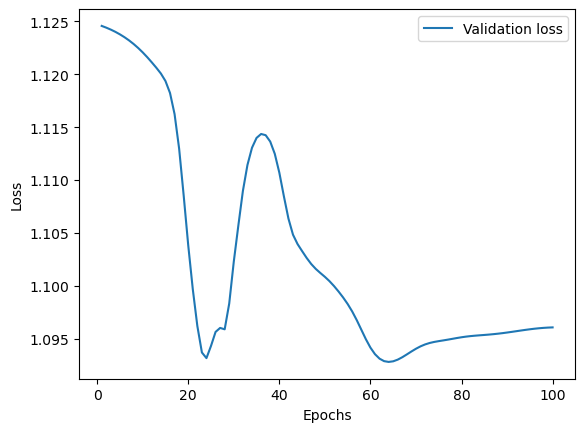

In [19]:
train_and_val(model_w_softmax, wines_train_X, wines_train_y, 100)

The loss starts to increase again at ~25, but the lowest validation is at 64

Number of epochs with lowest validation: 59


/var/folders/m8/skfw9g2x4_g4pq5cv80_g24w0000gn/T/ipykernel_8594/2244072975.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_X = torch.tensor(train_X, dtype=torch.float)
/var/folders/m8/skfw9g2x4_g4pq5cv80_g24w0000gn/T/ipykernel_8594/2244072975.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(train_y, dtype=torch.long)


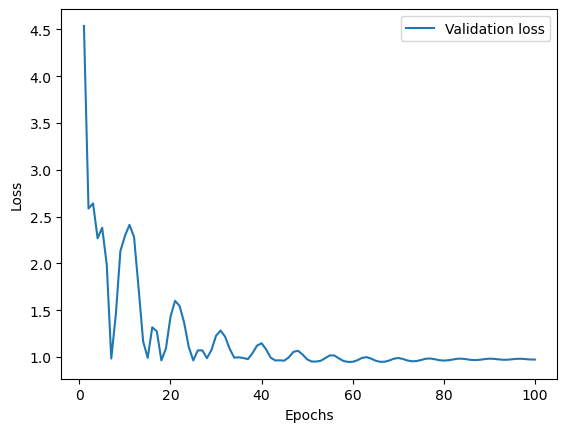

In [36]:
train_and_val(model_wo_softmax, wines_train_X, wines_train_y, 100)

In [ ]:
### CALCULATE ACCURACY OF EACH
# calculate_accuracy(model,xs,ys)
def calculate_accuracy_nn(model,xs,ys):
    y_pred=np.zeros_like(ys)
    for idx,x in enumerate(xs):
        y_pred[idx]=model.forward(x)
    return np.sum(ys==y_pred)/len(ys)

calculate_accuracy_nn(model,train_Xs,train_ys)
calculate_accuracy_nn(model_wo_softmax, wines_train_X, wines_train_y)